### Parte 0: Introdução

- FinRL é uma biblioteca de Aprendizagem por Reforço

- Testaremos os modelos com a mesma composição do BOVA11

- Dados de composição coletados pela página:
https://www.blackrock.com/br/products/251816/ishares-ibovespa-fundo-de-ndice-fund



### Parte 1: Primeiros passos - Carregar pacotes

1. Instale todos os pacotes através da biblioteca **FinRL**
2. Instale a biblioteca **pyportfolioopt** para estudo de Portifólios
3. Instale a biblioteca **uniqed** para a remoção de Outliers de Preço

In [ ]:
!pip install wrds
!pip install swig
!pip install yfinance
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install pyportfolioopt
!pip install uniqed

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-v4aplxry
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-v4aplxry
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit b781b80727bb8848e7addcfd6fa61e1ff6b06fa3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-oyaz847_/elegantrl_92f13b95b07f4c198e679c4fcea0a9ef
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-oyaz847_/elegantrl_92f13b95b07f4c198e679c4fcea0a9ef
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 4c1893aeeb350e952bdcce916b13e6650a84cd68
  Preparing metadata (setup.py) ... done


In [ ]:
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
import time
import os
from finrl.main import check_and_make_directories
import datetime
import matplotlib.dates as mdates
from uniqed.runners.tof_run import detect_outlier
import pandas as pd
import numpy as np
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

import sys
sys.path.append("../FinRL-Library")

import itertools

sns.set_style("darkgrid")

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


#### Definindo os Tickers

- Os tickers coletados são utilizados para executar a função .download()

- Dados OHLCV de cada Ticker são coletados

In [ ]:
warnings.filterwarnings("ignore")

tickers = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "PETR3.SA", "BBDC4.SA", "B3SA3.SA", "ELET3.SA", "BBAS3.SA", "ABEV3.SA",
    "WEGE3.SA", "RENT3.SA", "ITSA4.SA", "PRIO3.SA", "BPAC11.SA", "SUZB3.SA", "RADL3.SA", "EQTL3.SA", "RDOR3.SA", "GGBR4.SA",
    "RAIL3.SA", "JBSS3.SA", "BBSE3.SA", "VBBR3.SA", "CSAN3.SA", "UGPA3.SA", "SBSP3.SA", "BBDC3.SA", "HAPV3.SA", "ENEV3.SA",
    "VIVT3.SA", "CMIG4.SA", "ASAI3.SA", "KLBN11.SA", "HYPE3.SA", "BRFS3.SA", "LREN3.SA", "TOTS3.SA", "EMBR3.SA", "CPLE6.SA",
    "ENGI11.SA", "NTCO3.SA", "CCRO3.SA", "ALSO3.SA", "TIMS3.SA", "EGIE3.SA", "ELET6.SA", "SANB11.SA", "GOAU4.SA", "RRRP3.SA",
    "TAEE11.SA", "MGLU3.SA", "CSNA3.SA", "MULT3.SA", "CPFE3.SA", "BRKM5.SA", "RECV3.SA", "YDUQ3.SA", "BRAP4.SA", "CYRE3.SA",
    "SMTO3.SA", "CRFB3.SA", "COGN3.SA", "FLRY3.SA", "CMIN3.SA", "VAMO3.SA", "AZUL4.SA", "RAIZ4.SA", "IGTI11.SA", "MRVE3.SA",
    "ARZZ3.SA", "CIEL3.SA", "SLCE3.SA", "SOMA3.SA", "USIM5.SA", "IRBR3.SA", "LWSA3.SA", "DXCO3.SA", "BEEF3.SA", "VIIA3.SA",
    "EZTC3.SA", "ALPA4.SA", "PETZ3.SA", "GOLL4.SA", "MRFG3.SA", "CVCB3.SA", "PCAR3.SA"]



def OHLCV(list_tickers, start, end):
    ohlcv = {}

    for t in list_tickers:
        time.sleep(0.5)
        try:
            data = yf.download(t, start=start, end=end, interval="1d", repair=True).dropna()
            if not data.empty:
                ohlcv[t] = data
        except:
            pass
    return ohlcv

ohlcv_dict = OHLCV(tickers,"2015-01-01","2023-09-09")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

#### Execução da biblioteca uniqed

- Adiciona-se aos dados OHLCV, colunas representando as anomalias de Adj Close de cada Ticker
- Remove-se da lista de ativos, tickers possuindo um grande número de anomalias de preço

In [ ]:
warnings.filterwarnings("ignore")

clean_price = {}

for t in ohlcv_dict.keys():
    try:
        clean_price[t] = detect_outlier(ohlcv_dict[t][["Adj Close"]], cutoff_n=80).dropna()
        clean_price[t][["Open", "High", "Low", "Close", "Volume"]] = ohlcv_dict[t][["Open", "High", "Low", "Close", "Volume"]]
    except:
        pass

In [ ]:
warnings.filterwarnings("ignore")

def remove_data(clean_price):
    df = pd.DataFrame()
    for t in clean_price.keys():
        try:
            df[t] = clean_price[t]["Adj Close"]
        except:
            continue

    sec_returns = np.log(1 + df.pct_change()) * 100

    sec_outliers = pd.DataFrame()

    for t in sec_returns.columns:
        try:
            sec_outliers[t] = detect_outlier(sec_returns[[t]], cutoff_n=150)["TOF"]
        except:
            pass

    valido_ativo = []
    for t in sec_outliers.columns:
        sec_returns_t = sec_returns[t].replace(0, np.nan).dropna()

        if not sec_returns_t.empty:
            sec_returns_t = sec_returns_t.ffill()

            posicao_outlier = sec_outliers.index[sec_outliers[t] == 1]

            if len(posicao_outlier) < 0.02 * len(sec_returns_t):
                valido_ativo.append(True)
            else:
                valido_ativo.append(False)
        else:
            valido_ativo.append(False)

    clean_price_filtro = {}
    for idx, t in enumerate(clean_price.keys()):
        if valido_ativo[idx]:
            clean_price_filtro[t] = clean_price[t]

    return clean_price_filtro

cleaner_price = remove_data(clean_price)

Dado Histórico: Adj Close


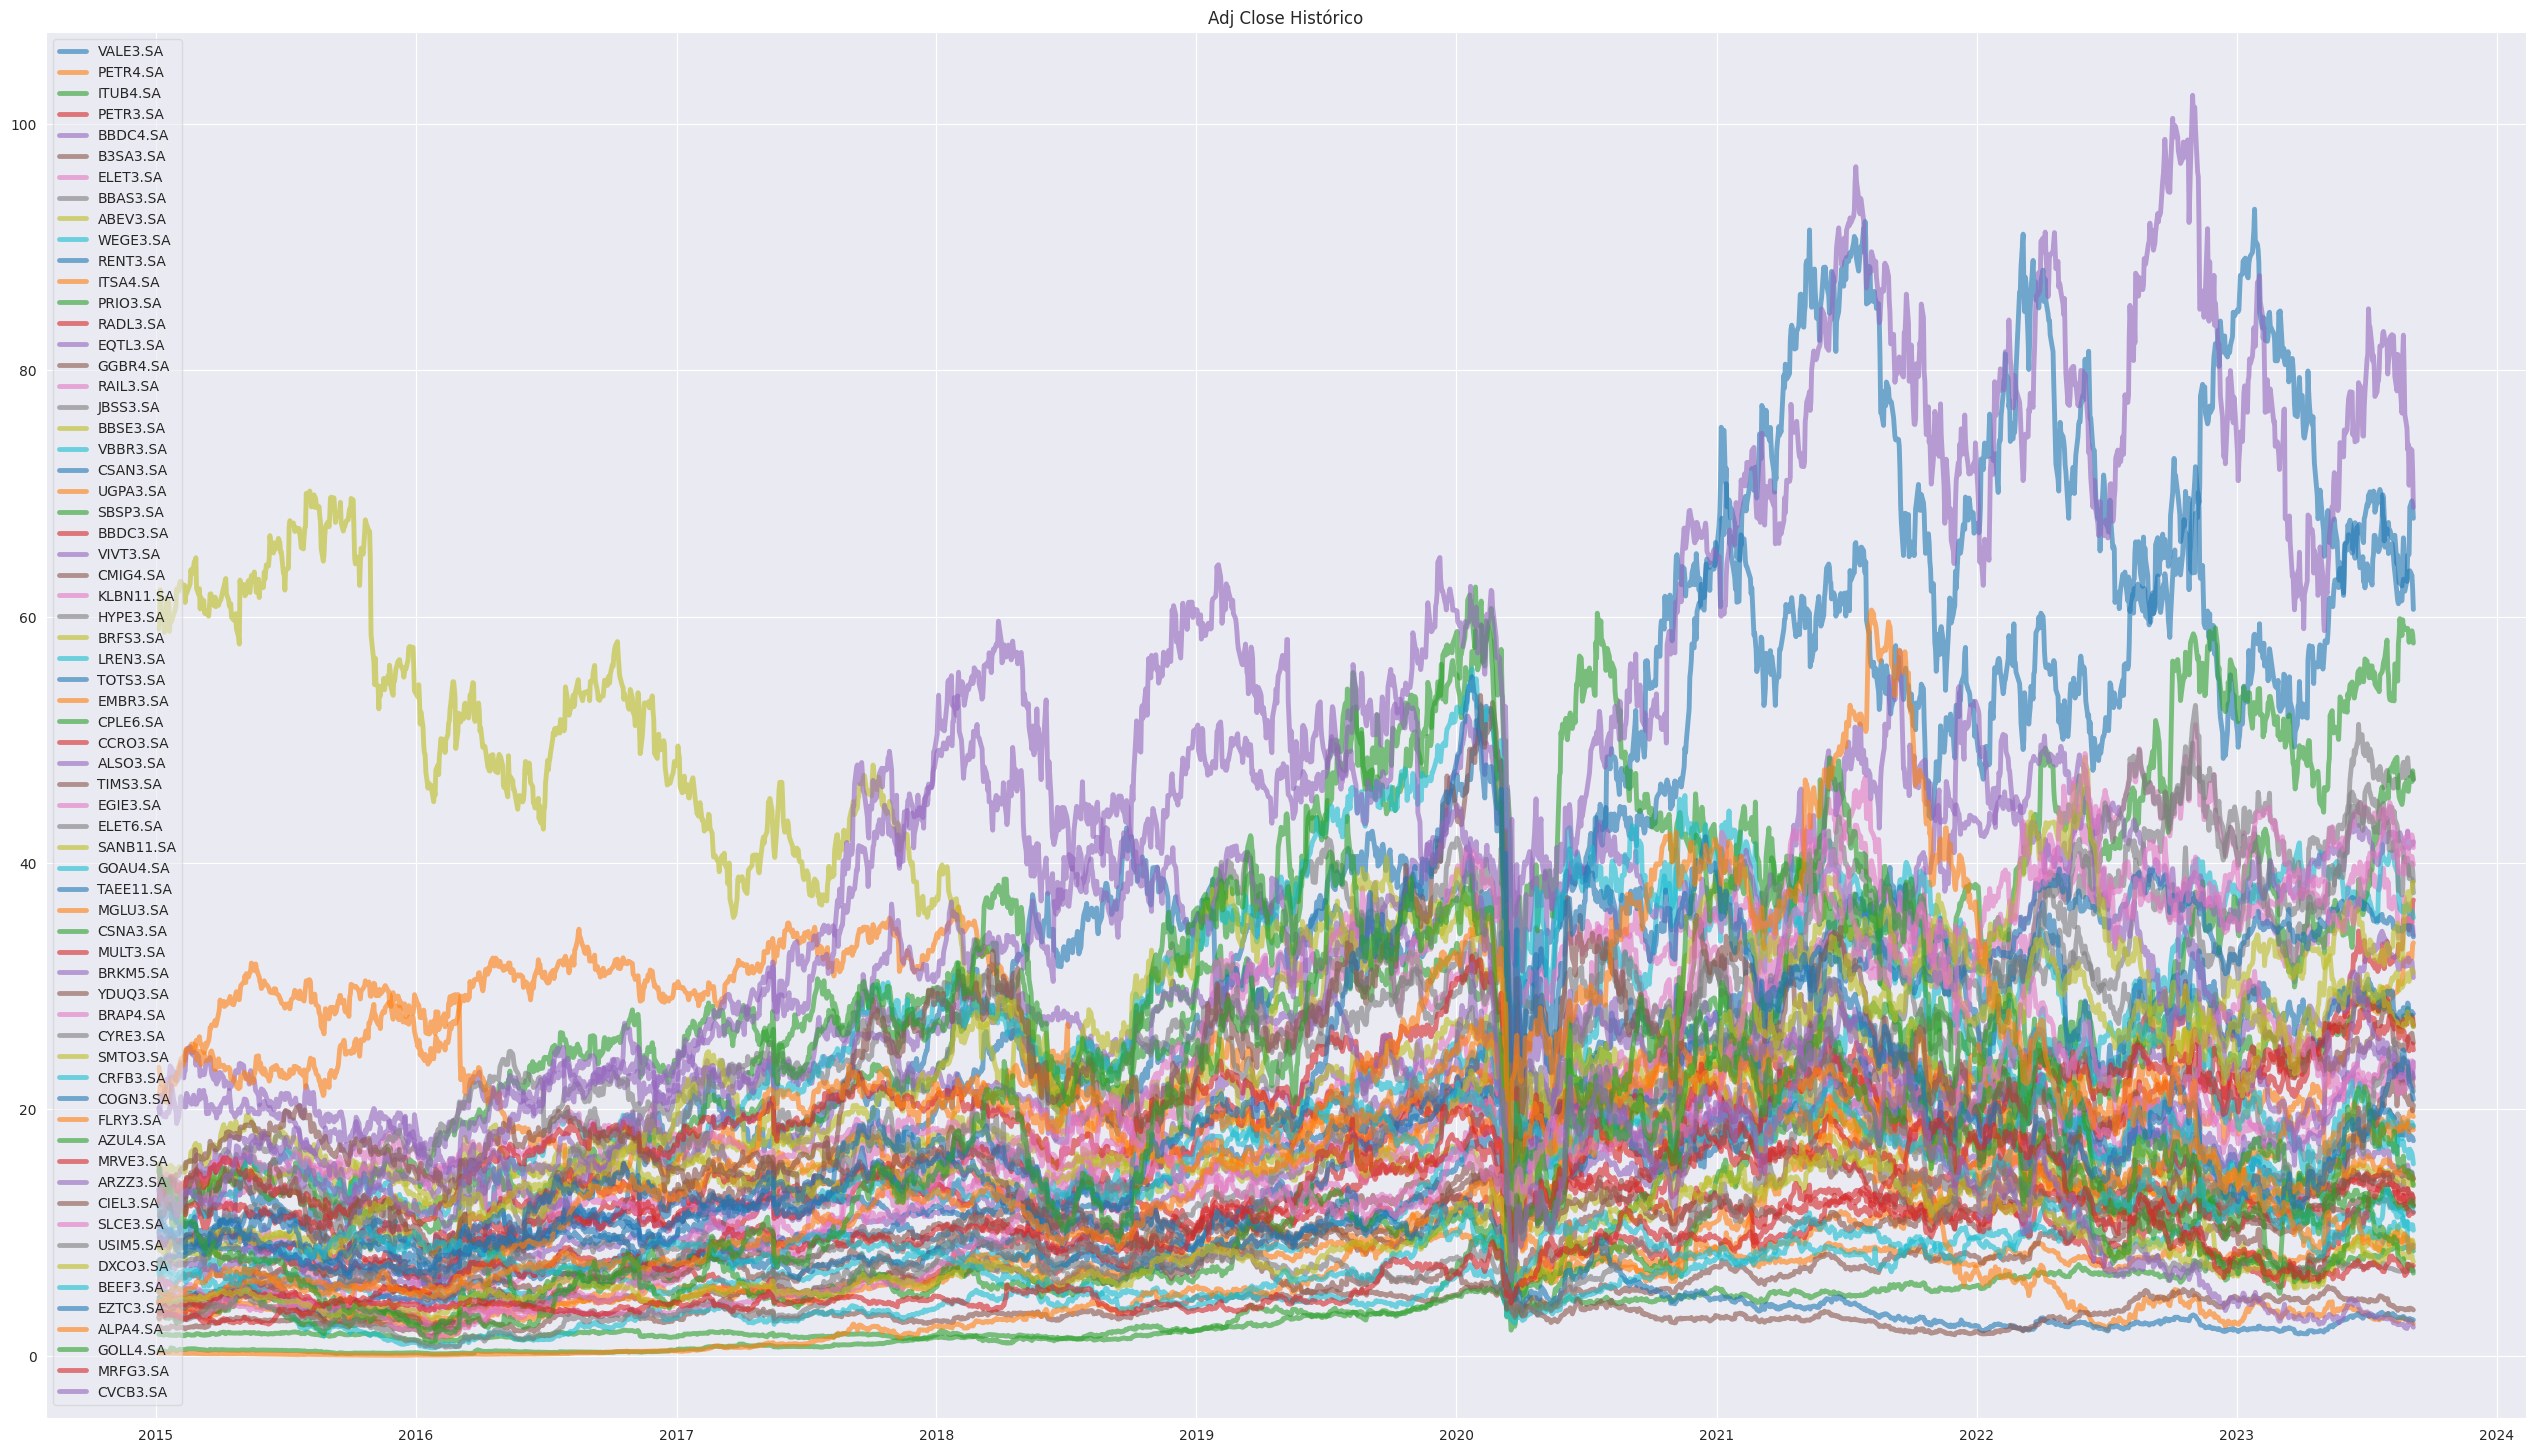

In [ ]:
warnings.filterwarnings("ignore")

def historical_values(source,index):

    ativos = [x for x in source.keys()]
    vol_med =[]

    if index == "Volume":
        if len(tickers)<17:
            plt.rcParams.update({"font.size": 19})
        else:
            plt.rcParams.update({"font.size": 18})

        plt.figure(figsize=(32, 18))
        print(f"Dado Histórico: {index} Médio")
        for t in source.keys():
            vol_med.append(source[t][index].mean() / 100)
        sorted_vol_med, sorted_ativos = zip(*sorted(zip(vol_med, ativos)))
        plt.bar(sorted_ativos, sorted_vol_med)
        plt.title(f"{index} Histórico Médio")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Dado Histórico: {index}")
        plt.figure(figsize=(32,18))
        for t in source.keys():
            plt.plot(source[t][index],alpha=0.6,lw=3.5)
            plt.legend([x for x in source.keys()],loc='upper left',framealpha=0.55)
        plt.title(f"{index} Histórico")
        plt.show()

%matplotlib inline
historical_values(cleaner_price,"Adj Close")

### Parte 2: Baixar Dados

In [ ]:
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2021-01-01'
TRADE_START_DATE = '2021-01-01'
TRADE_END_DATE = '2023-09-09'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = [x for x in cleaner_price.keys()]).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
warnings.filterwarnings("ignore")

df.head()

,date,open,high,low,close,volume,tic,day
0,2015-01-02,16.139999,16.559999,15.770000,11.537621,19396500,ABEV3.SA,4
1,2015-01-02,5.744000,5.792000,5.520000,4.523073,373000,ALPA4.SA,4
2,2015-01-02,16.750000,16.990000,16.750000,14.291426,6800,ALSO3.SA,4
3,2015-01-02,26.620001,26.680000,25.379999,20.779966,94700,ARZZ3.SA,4
4,2015-01-02,3.270000,3.270000,3.150000,2.291850,21734100,B3SA3.SA,4


In [ ]:
warnings.filterwarnings("ignore")

df.shape

(138407, 8)

In [ ]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2015-01-02,16.139999,16.559999,15.770000,11.537621,19396500,ABEV3.SA,4
1,2015-01-02,5.744000,5.792000,5.520000,4.523073,373000,ALPA4.SA,4
2,2015-01-02,16.750000,16.990000,16.750000,14.291426,6800,ALSO3.SA,4
3,2015-01-02,26.620001,26.680000,25.379999,20.779966,94700,ARZZ3.SA,4
4,2015-01-02,3.270000,3.270000,3.150000,2.291850,21734100,B3SA3.SA,4


### Parte 3: Pré-processar dados

In [ ]:
warnings.filterwarnings("ignore")

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processada = fe.preprocess_data(df)
processada = processada.copy()
processada = processada.fillna(0)
processada = processada.replace(np.inf,0)
processada.head()

Successfully added technical indicators
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2015-01-02,16.139999,16.559999,15.770000,11.537621,19396500,ABEV3.SA,4,0.0,11.728562,11.137821,0.0,-66.666667,100.0,11.537621,11.537621,0.0
1,2015-01-02,5.744000,5.792000,5.520000,4.523073,373000,ALPA4.SA,4,0.0,11.728562,11.137821,0.0,-66.666667,100.0,4.523073,4.523073,0.0
2,2015-01-02,16.750000,16.990000,16.750000,14.291426,6800,ALSO3.SA,4,0.0,11.728562,11.137821,0.0,-66.666667,100.0,14.291426,14.291426,0.0
3,2015-01-02,26.620001,26.680000,25.379999,20.779966,94700,ARZZ3.SA,4,0.0,11.728562,11.137821,0.0,-66.666667,100.0,20.779966,20.779966,0.0
4,2015-01-02,3.270000,3.270000,3.150000,2.291850,21734100,B3SA3.SA,4,0.0,11.728562,11.137821,0.0,-66.666667,100.0,2.291850,2.291850,0.0


In [ ]:
warnings.filterwarnings("ignore")

lista_ticker = processada["tic"].unique().tolist()
lista_data = list(pd.date_range(processada['date'].min(),processada['date'].max()).astype(str))
combinacao = list(itertools.product(lista_data,lista_ticker))

processada_full = pd.DataFrame(combinacao,columns=["date","tic"]).merge(processada,on=["date","tic"],how="left")
processada_full = processada_full[processada_full['date'].isin(processada['date'])]
processada_full = processada_full.sort_values(['date','tic'])

processada_full = processada_full.fillna(0)
mvo_df = processada_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
processada_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2015-01-02,ABEV3.SA,16.139999,16.559999,15.770000,11.537621,19396500.0,4.0,0.0,11.728562,11.137821,0.0,-66.666667,100.0,11.537621,11.537621,0.0
1,2015-01-02,ALPA4.SA,5.744000,5.792000,5.520000,4.523073,373000.0,4.0,0.0,11.728562,11.137821,0.0,-66.666667,100.0,4.523073,4.523073,0.0
2,2015-01-02,ALSO3.SA,16.750000,16.990000,16.750000,14.291426,6800.0,4.0,0.0,11.728562,11.137821,0.0,-66.666667,100.0,14.291426,14.291426,0.0
3,2015-01-02,ARZZ3.SA,26.620001,26.680000,25.379999,20.779966,94700.0,4.0,0.0,11.728562,11.137821,0.0,-66.666667,100.0,20.779966,20.779966,0.0
4,2015-01-02,B3SA3.SA,3.270000,3.270000,3.150000,2.291850,21734100.0,4.0,0.0,11.728562,11.137821,0.0,-66.666667,100.0,2.291850,2.291850,0.0


In [ ]:
warnings.filterwarnings("ignore")

train = data_split(processada_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processada_full, TRADE_START_DATE,TRADE_END_DATE)
train_comprimento = len(train)
trade_comprimento = len(trade)
print(f"O tamanho do conjunto de treino é: {train_comprimento}")
print(f"O tamanho do conjunto de trade é: {trade_comprimento}")

O tamanho do conjunto de treino é: 86478
O tamanho do conjunto de trade é: 38860


### Parte 4: Design do Ambiente

In [ ]:
warnings.filterwarnings("ignore")

ativo_dimensao = len(train.tic.unique())
espaco_acao = 1 + 2*ativo_dimensao + len(INDICATORS)*ativo_dimensao
print(f"Dimensão de ativos: {ativo_dimensao}, Espaço de Ação: {espaco_acao}")

Dimensão de ativos: 58, Espaço de Ação: 581


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * ativo_dimensao
num_acoes = [0] * ativo_dimensao

env_kwargs = {
    "hmax": 100,
    "initial_amount": int(input("Insira o valor inicial: ")),
    "num_stock_shares": num_acoes,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": espaco_acao,
    "stock_dim": ativo_dimensao,
    "tech_indicator_list": INDICATORS,
    "action_space": ativo_dimensao,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Insira o valor inicial: 10000
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Parte 5: Implementar Algoritmos DRL

- Resultados observados são **In-Sample**

In [ ]:
agent = DRLAgent(env = env_train)

usando_a2c = True
usando_ddpg = True
usando_ppo = True
usando_td3 = True
usando_sac = True

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if usando_a2c:
    tmp_path = RESULTS_DIR + '/a2c'
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_a2c.set_logger(new_logger_a2c)

trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if usando_a2c else None

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c
-----------------------------------------
| time/                 |               |
|    fps                | 122           |
|    iterations         | 100           |
|    time_elapsed       | 4             |
|    total_timesteps    | 500           |
| train/                |               |
|    entropy_loss       | -82.7         |
|    explained_variance | -859          |
|    learning_rate      | 0.0007        |
|    n_updates          | 99            |
|    policy_loss        | -40.3         |
|    reward             | -0.0004117946 |
|    std                | 1.01          |
|    value_loss         | 0.332         |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 125         |
|    iterations         | 200         |
|    time_elapsed       | 7           |
|    total_timesteps    | 1000

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if usando_ddpg:
    tmp_path = RESULTS_DIR + '/ddpg'
    new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_ddpg.set_logger(new_logger_ddpg)

trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if usando_ddpg else None

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg
-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 62           |
|    time_elapsed    | 95           |
|    total_timesteps | 5964         |
| train/             |              |
|    actor_loss      | -2.75        |
|    critic_loss     | 0.0234       |
|    learning_rate   | 0.001        |
|    n_updates       | 4473         |
|    reward          | -0.019940717 |
-------------------------------------
day: 1490, episode: 40
begin_total_asset: 10000.00
end_total_asset: 29463.77
total_reward: 19463.77
total_cost: 9.99
total_trades: 40230
Sharpe: 0.795
-------------------------------------
| time/              |              |
|    episodes        | 8            |
|    fps             | 57           |
|    time_elapsed    | 208          |
|    total_timesteps | 11928        |
| train/            

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if usando_ppo:
    tmp_path = RESULTS_DIR + '/ppo'
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_ppo.set_logger(new_logger_ppo)

trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if usando_ppo else None

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo
------------------------------------
| time/              |             |
|    fps             | 137         |
|    iterations      | 1           |
|    time_elapsed    | 14          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.013972251 |
------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 133          |
|    iterations           | 2            |
|    time_elapsed         | 30           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.043104045  |
|    clip_fraction        | 0.405        |
|    clip_range           | 0.2          |
|    entropy_loss         | -82.4        |
|    explained_variance   | -3.19        |
|    learning_rate        | 0.

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if usando_td3:
    tmp_path = RESULTS_DIR + '/td3'
    new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_td3.set_logger(new_logger_td3)

trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if usando_td3 else None

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3
--------------------------------------
| time/              |               |
|    episodes        | 4             |
|    fps             | 65            |
|    time_elapsed    | 90            |
|    total_timesteps | 5964          |
| train/             |               |
|    actor_loss      | 6.98          |
|    critic_loss     | 0.126         |
|    learning_rate   | 0.001         |
|    n_updates       | 4473          |
|    reward          | 0.00053885154 |
--------------------------------------
day: 1490, episode: 110
begin_total_asset: 10000.00
end_total_asset: 23043.57
total_reward: 13043.57
total_cost: 9.99
total_trades: 52150
Sharpe: 0.617
--------------------------------------
| time/              |               |
|    episodes        | 8             |
|    fps             | 60            |
|    time_elapsed    | 195           |
|    total_timesteps | 11928         |

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if usando_sac:
    tmp_path = RESULTS_DIR + '/sac'
    new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_sac.set_logger(new_logger_sac)

trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000) if usando_sac else None

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac
-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 41           |
|    time_elapsed    | 142          |
|    total_timesteps | 5964         |
| train/             |              |
|    actor_loss      | -65.8        |
|    critic_loss     | 0.136        |
|    ent_coef        | 0.056        |
|    ent_coef_loss   | -281         |
|    learning_rate   | 0.0001       |
|    n_updates       | 5863         |
|    reward          | 0.0024884834 |
-------------------------------------
-------------------------------------
| time/              |              |
|    episodes        | 8            |
|    fps             | 41           |
|    time_elapsed    | 288          |
|    total_timesteps | 11928        |
| train/             |              |
|    act

### Parte 6: Definir limite de turbulência

In [ ]:
warnings.filterwarnings("ignore")

indicador_risco = processada_full[(processada_full.date<TRAIN_END_DATE) & (processada_full.date>=TRAIN_START_DATE)]
insample_indicador = indicador_risco.drop_duplicates(subset=['date'])
insample_indicador.describe()

,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
count,1491.000000,1491.000000,1491.000000,1491.000000,1.491000e+03,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000
mean,18.055372,18.259497,17.850872,14.943566,1.763086e+07,2.000000,0.003180,15.678082,14.182406,51.523369,13.898958,23.084916,14.927655,14.929333,73.220249
std,2.449082,2.426015,2.471706,1.896098,1.189595e+07,1.407077,0.263137,1.855648,1.958073,9.408757,113.418270,17.139754,1.844411,1.763200,87.363152
min,10.730000,11.210000,10.360000,9.777991,0.000000e+00,0.000000,-1.255295,10.716441,8.661926,0.000000,-364.632674,0.060354,10.416856,10.666699,0.000000
25%,17.080000,17.290001,16.879999,14.054151,1.043760e+07,1.000000,-0.117756,14.680464,13.290107,46.173309,-73.894139,9.561104,14.007953,14.102295,38.172689
50%,18.440001,18.670000,18.260000,14.986991,1.459120e+07,2.000000,0.052750,15.596890,14.344546,51.950016,22.222855,19.825984,14.989619,14.943224,58.775918
75%,19.299999,19.480000,19.110001,15.903796,2.116945e+07,3.000000,0.173181,16.554164,15.166822,56.747120,98.147084,33.343252,15.833277,15.905750,87.010688
max,24.389999,24.559999,24.030001,20.366478,1.440625e+08,4.000000,0.550359,20.795733,19.639271,88.143730,350.254471,100.000000,19.903821,19.431092,1095.172715


### Parte 7: Trading (**Out-of-sample**)

In [ ]:
warnings.filterwarnings("ignore")

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, **env_kwargs)

In [ ]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


### Parte 8: Otimização Média-Variância

In [ ]:
def processa_df_mvo(df):
    df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
    fst = df
    fst = fst.iloc[0:ativo_dimensao, :]
    tic = fst['tic'].tolist()

    mvo = pd.DataFrame()

    for k in range(len(tic)):
        mvo[tic[k]] = 0

    for i in range(df.shape[0]//ativo_dimensao):
        n = df
        n = n.iloc[i * ativo_dimensao:(i+1) * ativo_dimensao, :]
        date = n['date'][i*ativo_dimensao]
        mvo.loc[date] = n['close'].tolist()

    return mvo

def StockReturnsComputing(StockPrice, Rows, Columns):
    import numpy as np
    StockReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):
        for i in range(Rows-1):
            StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

    return StockReturn

In [ ]:
train_mvo = data_split(processada_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processada_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

StockData = processa_df_mvo(train_mvo)
TradeData = processa_df_mvo(trade_mvo)

TradeData.to_numpy()

array([[14.0857172 , 41.19131088, 26.65495682, ..., 38.51199341,
        35.79328918, 32.80754089],
       [14.38599586, 41.21108627, 26.64549637, ..., 38.18503952,
        37.99020004, 32.97157669],
       [14.67717171, 38.96609116, 25.22667503, ..., 37.75751114,
        38.99751663, 31.65927696],
       ...,
       [14.01000023,  8.94999981, 22.85000038, ..., 41.45999908,
        35.90999985, 19.87000084],
       [13.97999954,  8.77000046, 22.54000092, ..., 41.72999954,
        35.54999924, 20.32999992],
       [13.69999981,  8.40999985, 22.60000038, ..., 41.86000061,
        35.40000153, 20.84000015]])

In [ ]:
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

# Retornos médios e matriz de covariância/variância de retornos
retornos_medios = np.mean(arReturns, axis = 0)
cov_retornos = np.cov(arReturns, rowvar=False)

np.set_printoptions(precision=3, suppress = True)

print('Retornos Médios dos Ativos no K-Portfólio 1\n', retornos_medios)
print('Matriz de Variância-Covariância dos Retornos\n', cov_retornos)

Retornos Médios dos Ativos no K-Portfólio 1
 [ 0.029  0.183  0.075  0.11   0.168  0.102  0.071  0.083  0.051  0.043
  0.171 -0.034  0.098  0.048 -0.06   0.08  -0.011  0.11   0.11   0.224
  0.09   0.13   0.115  0.074  0.207  0.174 -0.028  0.12   0.126  0.118
  0.125  0.075  0.162  0.085  0.081  0.077  0.115  0.12   0.404  0.108
  0.131  0.068  0.14   0.137  0.363  0.132  0.171  0.11   0.153  0.091
  0.049  0.096  0.032  0.16   0.159  0.063  0.156  0.104]
Matriz de Variância-Covariância dos Retornos
 [[ 3.03   1.274  1.447 ...  1.094  1.522  2.02 ]
 [ 1.274  6.834  2.548 ...  1.271  1.855  2.573]
 [ 1.447  2.548  6.18  ...  1.416  1.393  2.95 ]
 ...
 [ 1.094  1.271  1.416 ...  4.032  1.079  1.754]
 [ 1.522  1.855  1.393 ...  1.079  4.829  2.255]
 [ 2.02   2.573  2.95  ...  1.754  2.255 11.988]]


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

fronteira_media = EfficientFrontier(retornos_medios, cov_retornos, weight_bounds=(0, 0.5))
peso_medio = fronteira_media.max_sharpe()
peso_medio_limpo = fronteira_media.clean_weights()
mvo_pesos = np.array([env_kwargs["initial_amount"] * peso_medio_limpo[i] for i in range(len(train.tic.unique()))])
mvo_pesos

array([   0. , 1015.3,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,  179.6,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
         15.2,    0. ,    0. ,  583. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. , 2556.8,    0. ,
          0. ,    0. ,    0. ,    0. , 1153.4, 1625.4,    0. ,    0. ,
       1902.9,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
        968.5,    0. ])

In [ ]:
ultimo_preco = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
portfolio_inicial = np.multiply(mvo_pesos, ultimo_preco)
ativos_portifolio = TradeData @ portfolio_inicial
MVO_resultado = pd.DataFrame(ativos_portifolio, columns=["Mean Var"])

### Parte 9: Backtest

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_td3.rename(columns = {'account_value':'td3'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_result_sac.rename(columns = {'account_value':'sac'}, inplace = True)


df_bova_ = get_baseline(
        ticker="BOVA11.SA",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_bova_, value_col_name = 'close')
df_bova = pd.DataFrame()
df_bova['date'] = df_account_value_a2c['date']
df_bova['BOVA11'] = df_bova_['close'] / df_bova_['close'][0] * env_kwargs["initial_amount"]
df_bova = df_bova.set_index(df_bova.columns[0])

resultado = pd.DataFrame()
resultado = pd.merge(resultado, df_result_a2c, how='outer', left_index=True, right_index=True)
resultado = pd.merge(resultado, df_result_ddpg, how='outer', left_index=True, right_index=True)
resultado = pd.merge(resultado, df_result_td3, how='outer', left_index=True, right_index=True)
resultado = pd.merge(resultado, df_result_ppo, how='outer', left_index=True, right_index=True)
resultado = pd.merge(resultado, df_result_sac, how='outer', left_index=True, right_index=True)
resultado = pd.merge(resultado, MVO_resultado, how='outer', left_index=True, right_index=True)
resultado = pd.merge(resultado, df_bova, how='outer', left_index=True, right_index=True)

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (670, 8)
Annual return         -0.008065
Cumulative returns    -0.021299
Annual volatility      0.210991
Sharpe ratio           0.067084
Calmar ratio          -0.030547
Stability              0.103281
Max drawdown          -0.264016
Omega ratio            1.010845
Sortino ratio          0.093212
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.905844
Daily value at risk   -0.026526
dtype: float64


<Figure size 1500x500 with 0 Axes>

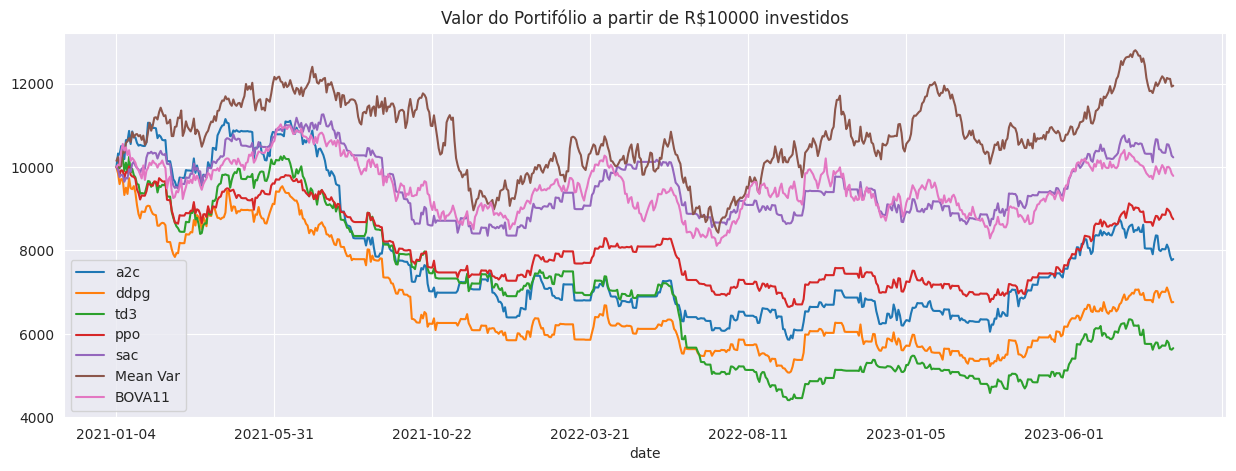

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
resultado.plot(title=f"Valor do Portifólio a partir de R${env_kwargs['initial_amount']} investidos");
plt.show()

In [ ]:
def melhor_modelo():
    valores_finais = {
        'a2c': df_account_value_a2c.iloc[-1, 1],
        'ddpg': df_account_value_ddpg.iloc[-1, 1],
        'td3': df_account_value_td3.iloc[-1, 1],
        'ppo': df_account_value_ppo.iloc[-1, 1],
        'sac': df_account_value_sac.iloc[-1, 1]
    }

    melhor_modelov = max(valores_finais, key=valores_finais.get)
    melhor_valor = valores_finais[melhor_modelov]

    global melhor_modelo_actions, melhor_modelo_source
    melhor_modelo_actions = f"df_actions_{melhor_modelov}"
    melhor_modelo_source = f"df_account_value_{melhor_modelov}"

    print(f"O modelo com melhor resultado foi o: {melhor_modelov}")
    print(f"Valor Final do Melhor Modelo: R${melhor_valor}")

melhor_modelo()

O modelo com melhor resultado foi o: sac
Valor Final do Melhor Modelo: R$10230.983797242534


In [ ]:
def metricas():
    df2 = globals()[melhor_modelo_actions]
    df2.index = pd.to_datetime(df2.index)

    holding_times = {}
    posicao_atual = {}
    for acao in df2.columns:
        if acao != 'YearMonth':
            holding_times[acao] = []
            posicao_atual[acao] = None

    for data, linha in df2.iterrows():
        for acao in df2.columns:
            if acao != 'YearMonth':
                acao_tomada = linha[acao]
                if acao_tomada == 0:
                    if posicao_atual[acao] is not None:
                        periodo_de_possao = (data - posicao_atual[acao]).days
                        holding_times[acao].append(periodo_de_possao)
                elif acao_tomada == 1 or acao_tomada == -1:
                    posicao_atual[acao] = data

    mean_holding_times = {acao: sum(tempos) / len(tempos) if tempos else 0 for acao, tempos in holding_times.items() if acao != 'YearMonth'}

    df2['YearMonth'] = df2.index.strftime('%Y-%m')
    negociacoes_mensais = df2[df2.isin([-1, 1]).any(axis=1)].groupby('YearMonth').size()

    media_negociacoes_mensais = negociacoes_mensais.mean()

    print(f"Tempo Médio de Holding: {round((sum(list(mean_holding_times.values())) / len(list(mean_holding_times.values())))/30, 2)} meses\n")
    for acao, holding_times in mean_holding_times.items():
        print(f"{acao}: {holding_times:.2f} dias")

    print(f"\nMédia Mensal do Número de Negociações da Carteira: {media_negociacoes_mensais:.2f}")

metricas()

Tempo Médio de Holding: 2.33 meses

ABEV3.SA: 0.00 dias
ALPA4.SA: 0.00 dias
ALSO3.SA: 0.00 dias
ARZZ3.SA: 0.00 dias
B3SA3.SA: 0.00 dias
BBAS3.SA: 173.62 dias
BBDC3.SA: 0.00 dias
BBDC4.SA: 0.00 dias
BBSE3.SA: 453.80 dias
BEEF3.SA: 0.00 dias
BRAP4.SA: 0.00 dias
BRFS3.SA: 0.00 dias
BRKM5.SA: 0.00 dias
CCRO3.SA: 164.39 dias
CIEL3.SA: 0.00 dias
CMIG4.SA: 0.00 dias
COGN3.SA: 0.00 dias
CPLE6.SA: 0.00 dias
CSAN3.SA: 0.00 dias
CSNA3.SA: 0.00 dias
CVCB3.SA: 27.05 dias
CYRE3.SA: 0.00 dias
DXCO3.SA: 281.74 dias
EGIE3.SA: 0.00 dias
ELET3.SA: 435.98 dias
ELET6.SA: 0.00 dias
EMBR3.SA: 470.35 dias
EQTL3.SA: 0.00 dias
EZTC3.SA: 271.58 dias
FLRY3.SA: 0.00 dias
GGBR4.SA: 0.00 dias
GOAU4.SA: 0.00 dias
GOLL4.SA: 0.00 dias
HYPE3.SA: 0.00 dias
ITSA4.SA: 30.02 dias
ITUB4.SA: 0.00 dias
JBSS3.SA: 0.00 dias
LREN3.SA: 0.00 dias
MGLU3.SA: 101.66 dias
MRFG3.SA: 439.48 dias
MRVE3.SA: 0.00 dias
MULT3.SA: 430.24 dias
PETR3.SA: 0.00 dias
PETR4.SA: 0.00 dias
PRIO3.SA: 0.00 dias
RADL3.SA: 0.00 dias
RENT3.SA: 0.00 dias
SB

In [ ]:
print("==============Resultado Backtest===========")

perf_stats = backtest_stats(account_value=globals()[melhor_modelo_source])
perf_stats = pd.DataFrame(perf_stats)

==============Resultado Backtest===========
Annual return          0.008626
Cumulative returns     0.023098
Annual volatility      0.181328
Sharpe ratio           0.137943
Calmar ratio           0.033401
Stability              0.059907
Max drawdown          -0.258256
Omega ratio            1.028835
Sortino ratio          0.200870
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.075692
Daily value at risk   -0.022746
dtype: float64


In [ ]:
print("==============Resultado Benchmark===========")

benchmark_df = get_baseline(
        ticker="BOVA11.SA",
        start = globals()[melhor_modelo_source].loc[0,'date'],
        end = globals()[melhor_modelo_source].loc[len(globals()[melhor_modelo_source])-1,'date'])

stats = backtest_stats(benchmark_df, value_col_name = 'close')

==============Resultado Benchmark===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (669, 8)
Annual return         -0.006106
Cumulative returns    -0.016128
Annual volatility      0.211124
Sharpe ratio           0.076534
Calmar ratio          -0.023127
Stability              0.104527
Max drawdown          -0.264016
Omega ratio            1.012381
Sortino ratio          0.106354
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.906051
Daily value at risk   -0.026535
dtype: float64
